# Residential Building Classification
This is a bare-bone version of the residential vs. non-residential building classification. We use DenseNet in this implementation. 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torchvision import transforms

import numpy as np
import cv2
import matplotlib.pyplot as plt

import params
from densenet_efficient import DenseNetEfficient
from solver import train, test_epoch
from dataset import *

# Load parameters
params = vars(params)
rbc_class_names = params['rbc_class_names']
fmow_class_names = params['fmow_class_names']
fmow_class_names_mini = params['fmow_class_names_mini']
dtype = params['dtype']

torch.set_num_threads(params['num_threads'])

## Preprocess FMOW Dataset
Check if fMoW dataset is available. If so, process the images by cropping based on given bounding boxes. Load in traing, validation and test dataset along with ground truth labels for training and validation set. 

In [2]:
mean = 0.5 #457.38
stdv = 0.25
train_transforms = transforms.Compose([
    Normalize(mean=mean, std=stdv),
    Rescale((224,224)),
    ToTensor(),
])
train_set = WCDataset(params, transform=train_transforms)
x,y = train_set[0]
print(type(x), x.shape, type(y), y.shape)

<class 'torch.FloatTensor'> torch.Size([1, 224, 224]) <class 'torch.LongTensor'> torch.Size([1])


In [3]:
mean = 0.5 #457.38
stdv = 0.25
test_transforms = transforms.Compose([
    Normalize(mean=mean, std=stdv),
    Rescale((224,224)),
    ToTensor(),
])
test_set = WCDataset(params, transform=test_transforms, train=False)
x,y = test_set[0]
print(type(x), x.shape, type(y), y.shape)

<class 'torch.FloatTensor'> torch.Size([1, 224, 224]) <class 'torch.LongTensor'> torch.Size([1])


In [4]:
# data_test = load_test(params, mean_image=None)
# X_test = data_test['X_test']
# y_test = data_test['y_test']
# X_test_tensor = torch.from_numpy(X_test)
# y_test_tensor = torch.from_numpy(y_test)
# test_data = TensorDataset(X_test_tensor, y_test_tensor)
# loader_test = DataLoader(test_data, batch_size=params['batch_size'], sampler=RandomSampler(X_test.shape[0]))
# print(X_test.shape, X_test.dtype)
# print(y_test.shape, y_test.dtype)
# print(y_test)

### Visualize a small batch of data
Plot a small batch of training images to get a sense of data

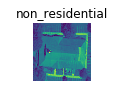

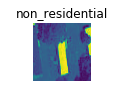

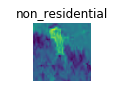

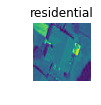

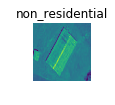

In [5]:
# Sample a minibatch and show the images and captions
size = 5
indices = np.random.choice(len(train_set), size, replace=False)

fig = plt.figure()

for i, idx in enumerate(indices):
    image, label = train_set[idx]
    plt.subplot(1, size, i + 1)
    plt.title(params['rbc_class_names'][label[0]])
    plt.axis('off')
    plt.imshow(image[0,:,:])
    plt.show()

## Load Model
Load in DenseNet. Configure training parameters. 

In [6]:
model = DenseNetEfficient(
        growth_rate=32, 
        block_config=(6, 12, 24, 16), 
        compression=0.5,
        num_init_features=64, 
        bn_size=4, 
        drop_rate=0,
        num_classes=20, 
        small_inputs=False)
# Move model to GPU
model = model.cuda()
# print(model)


/home/feng/anaconda3/envs/rbc_env/lib/python3.6/site-packages/torch/nn/modules/container.py:13: UserWarning: nn.Container is deprecated. All of it's functionality is now implemented in nn.Module. Subclass that instead.
  warnings.warn("nn.Container is deprecated. All of it's functionality "


In [7]:
# Load an existing model trained on 20 categories
model.load_state_dict(torch.load('/home/feng/ext2/feng/workspace/residential_building_challenge/output/model.dat'))

In [8]:
# Modify the model to predict 2 categories
model.classifier = nn.Sequential(
              nn.Linear(1024, 128),
              nn.ReLU(),
              nn.Linear(128, 2))

## Train Model
Train the model one epoch at a time. Keep the verbose option on to monitor the loss during training. 
Save training and validation accuracy history for visualization. 

In [9]:
train(model, 
      train_set, 
      None, 
      '/home/feng/ext2/feng/workspace/residential_building_challenge/20to2_output', 
      n_epochs=20, 
      valid_size=1000,
      batch_size=50, 
      lr=0.01, 
      wd=0.0001, 
      momentum=0.9, 
      seed=None)

Epoch: [1/20]	Iter: [1/226]	Time 1.149 (1.149)	Loss 0.6752 (0.6752)	Error 0.3600 (0.3600)
Epoch: [1/20]	Iter: [2/226]	Time 0.758 (0.953)	Loss 0.6799 (0.6776)	Error 0.4200 (0.3900)
Epoch: [1/20]	Iter: [3/226]	Time 0.662 (0.856)	Loss 0.6987 (0.6846)	Error 0.5200 (0.4333)
Epoch: [1/20]	Iter: [4/226]	Time 0.662 (0.808)	Loss 0.6616 (0.6788)	Error 0.3000 (0.4000)
Epoch: [1/20]	Iter: [5/226]	Time 0.667 (0.780)	Loss 0.6834 (0.6798)	Error 0.4600 (0.4120)
Epoch: [1/20]	Iter: [6/226]	Time 0.668 (0.761)	Loss 0.6996 (0.6831)	Error 0.5600 (0.4367)
Epoch: [1/20]	Iter: [7/226]	Time 0.664 (0.747)	Loss 0.6988 (0.6853)	Error 0.5200 (0.4486)
Epoch: [1/20]	Iter: [8/226]	Time 0.663 (0.737)	Loss 0.6822 (0.6849)	Error 0.4800 (0.4525)
Epoch: [1/20]	Iter: [9/226]	Time 0.667 (0.729)	Loss 0.6815 (0.6845)	Error 0.4800 (0.4556)
Epoch: [1/20]	Iter: [10/226]	Time 0.664 (0.722)	Loss 0.6805 (0.6841)	Error 0.4600 (0.4560)
Epoch: [1/20]	Iter: [11/226]	Time 0.669 (0.718)	Loss 0.6765 (0.6834)	Error 0.5200 (0.4618)
Epoch: [

Epoch: [1/20]	Iter: [92/226]	Time 0.665 (0.673)	Loss 0.3919 (0.5441)	Error 0.2000 (0.2833)
Epoch: [1/20]	Iter: [93/226]	Time 0.668 (0.673)	Loss 0.5465 (0.5442)	Error 0.2800 (0.2832)
Epoch: [1/20]	Iter: [94/226]	Time 0.668 (0.673)	Loss 0.3973 (0.5426)	Error 0.2000 (0.2823)
Epoch: [1/20]	Iter: [95/226]	Time 0.668 (0.673)	Loss 0.3604 (0.5407)	Error 0.2000 (0.2815)
Epoch: [1/20]	Iter: [96/226]	Time 0.669 (0.673)	Loss 0.4596 (0.5398)	Error 0.2600 (0.2812)
Epoch: [1/20]	Iter: [97/226]	Time 0.670 (0.673)	Loss 0.3174 (0.5375)	Error 0.1400 (0.2798)
Epoch: [1/20]	Iter: [98/226]	Time 0.667 (0.673)	Loss 0.5348 (0.5375)	Error 0.2600 (0.2796)
Epoch: [1/20]	Iter: [99/226]	Time 0.674 (0.673)	Loss 0.3043 (0.5352)	Error 0.1600 (0.2784)
Epoch: [1/20]	Iter: [100/226]	Time 0.683 (0.673)	Loss 0.3289 (0.5331)	Error 0.1400 (0.2770)
Epoch: [1/20]	Iter: [101/226]	Time 0.687 (0.673)	Loss 0.4513 (0.5323)	Error 0.1400 (0.2756)
Epoch: [1/20]	Iter: [102/226]	Time 0.693 (0.674)	Loss 0.4237 (0.5312)	Error 0.2200 (0.27

Epoch: [1/20]	Iter: [182/226]	Time 0.678 (0.676)	Loss 0.2328 (0.4519)	Error 0.0800 (0.2224)
Epoch: [1/20]	Iter: [183/226]	Time 0.678 (0.676)	Loss 0.3115 (0.4512)	Error 0.1400 (0.2220)
Epoch: [1/20]	Iter: [184/226]	Time 0.680 (0.676)	Loss 0.2457 (0.4501)	Error 0.1200 (0.2214)
Epoch: [1/20]	Iter: [185/226]	Time 0.683 (0.676)	Loss 0.3198 (0.4494)	Error 0.1600 (0.2211)
Epoch: [1/20]	Iter: [186/226]	Time 0.680 (0.676)	Loss 0.3790 (0.4490)	Error 0.2000 (0.2210)
Epoch: [1/20]	Iter: [187/226]	Time 0.674 (0.676)	Loss 0.3375 (0.4484)	Error 0.2000 (0.2209)
Epoch: [1/20]	Iter: [188/226]	Time 0.679 (0.676)	Loss 0.3617 (0.4479)	Error 0.1600 (0.2205)
Epoch: [1/20]	Iter: [189/226]	Time 0.679 (0.676)	Loss 0.3194 (0.4472)	Error 0.1800 (0.2203)
Epoch: [1/20]	Iter: [190/226]	Time 0.671 (0.676)	Loss 0.3823 (0.4469)	Error 0.1600 (0.2200)
Epoch: [1/20]	Iter: [191/226]	Time 0.673 (0.676)	Loss 0.3422 (0.4464)	Error 0.1600 (0.2197)
Epoch: [1/20]	Iter: [192/226]	Time 0.677 (0.676)	Loss 0.4888 (0.4466)	Error 0.22

Epoch: [2/20]	Iter: [27/226]	Time 0.673 (0.669)	Loss 0.2054 (0.2804)	Error 0.0800 (0.1178)
Epoch: [2/20]	Iter: [28/226]	Time 0.674 (0.669)	Loss 0.3080 (0.2814)	Error 0.1200 (0.1179)
Epoch: [2/20]	Iter: [29/226]	Time 0.669 (0.669)	Loss 0.1710 (0.2776)	Error 0.0400 (0.1152)
Epoch: [2/20]	Iter: [30/226]	Time 0.672 (0.669)	Loss 0.2013 (0.2750)	Error 0.0600 (0.1133)
Epoch: [2/20]	Iter: [31/226]	Time 0.674 (0.669)	Loss 0.2645 (0.2747)	Error 0.1200 (0.1135)
Epoch: [2/20]	Iter: [32/226]	Time 0.667 (0.669)	Loss 0.4041 (0.2787)	Error 0.1400 (0.1144)
Epoch: [2/20]	Iter: [33/226]	Time 0.670 (0.669)	Loss 0.2117 (0.2767)	Error 0.0800 (0.1133)
Epoch: [2/20]	Iter: [34/226]	Time 0.674 (0.669)	Loss 0.1767 (0.2738)	Error 0.0800 (0.1124)
Epoch: [2/20]	Iter: [35/226]	Time 0.666 (0.669)	Loss 0.2713 (0.2737)	Error 0.1000 (0.1120)
Epoch: [2/20]	Iter: [36/226]	Time 0.673 (0.670)	Loss 0.3365 (0.2754)	Error 0.1600 (0.1133)
Epoch: [2/20]	Iter: [37/226]	Time 0.671 (0.670)	Loss 0.4212 (0.2794)	Error 0.1400 (0.1141)

Epoch: [2/20]	Iter: [117/226]	Time 0.676 (0.674)	Loss 0.2790 (0.2722)	Error 0.1400 (0.1109)
Epoch: [2/20]	Iter: [118/226]	Time 0.672 (0.674)	Loss 0.3145 (0.2725)	Error 0.1400 (0.1112)
Epoch: [2/20]	Iter: [119/226]	Time 0.670 (0.674)	Loss 0.2646 (0.2725)	Error 0.1400 (0.1114)
Epoch: [2/20]	Iter: [120/226]	Time 0.674 (0.674)	Loss 0.3377 (0.2730)	Error 0.1400 (0.1117)
Epoch: [2/20]	Iter: [121/226]	Time 0.674 (0.674)	Loss 0.2839 (0.2731)	Error 0.1600 (0.1121)
Epoch: [2/20]	Iter: [122/226]	Time 0.670 (0.674)	Loss 0.2070 (0.2726)	Error 0.0400 (0.1115)
Epoch: [2/20]	Iter: [123/226]	Time 0.672 (0.674)	Loss 0.1886 (0.2719)	Error 0.0800 (0.1112)
Epoch: [2/20]	Iter: [124/226]	Time 0.671 (0.674)	Loss 0.3734 (0.2727)	Error 0.1600 (0.1116)
Epoch: [2/20]	Iter: [125/226]	Time 0.677 (0.674)	Loss 0.2909 (0.2728)	Error 0.1400 (0.1118)
Epoch: [2/20]	Iter: [126/226]	Time 0.676 (0.674)	Loss 0.1538 (0.2719)	Error 0.0600 (0.1114)
Epoch: [2/20]	Iter: [127/226]	Time 0.676 (0.674)	Loss 0.2239 (0.2715)	Error 0.08

Epoch: [2/20]	Iter: [207/226]	Time 0.674 (0.674)	Loss 0.3586 (0.2669)	Error 0.1200 (0.1117)
Epoch: [2/20]	Iter: [208/226]	Time 0.677 (0.674)	Loss 0.1605 (0.2664)	Error 0.0600 (0.1114)
Epoch: [2/20]	Iter: [209/226]	Time 0.675 (0.674)	Loss 0.2914 (0.2665)	Error 0.1200 (0.1115)
Epoch: [2/20]	Iter: [210/226]	Time 0.676 (0.674)	Loss 0.3667 (0.2670)	Error 0.1800 (0.1118)
Epoch: [2/20]	Iter: [211/226]	Time 0.671 (0.674)	Loss 0.4279 (0.2678)	Error 0.2000 (0.1122)
Epoch: [2/20]	Iter: [212/226]	Time 0.675 (0.674)	Loss 0.1498 (0.2672)	Error 0.0600 (0.1120)
Epoch: [2/20]	Iter: [213/226]	Time 0.668 (0.674)	Loss 0.2113 (0.2669)	Error 0.1200 (0.1120)
Epoch: [2/20]	Iter: [214/226]	Time 0.673 (0.674)	Loss 0.2841 (0.2670)	Error 0.1400 (0.1121)
Epoch: [2/20]	Iter: [215/226]	Time 0.671 (0.674)	Loss 0.2368 (0.2669)	Error 0.1000 (0.1121)
Epoch: [2/20]	Iter: [216/226]	Time 0.673 (0.674)	Loss 0.2315 (0.2667)	Error 0.1000 (0.1120)
Epoch: [2/20]	Iter: [217/226]	Time 0.673 (0.674)	Loss 0.1547 (0.2662)	Error 0.04

Epoch: [3/20]	Iter: [53/226]	Time 0.672 (0.669)	Loss 0.2114 (0.1801)	Error 0.1000 (0.0694)
Epoch: [3/20]	Iter: [54/226]	Time 0.673 (0.669)	Loss 0.1611 (0.1798)	Error 0.0600 (0.0693)
Epoch: [3/20]	Iter: [55/226]	Time 0.667 (0.669)	Loss 0.1874 (0.1799)	Error 0.0800 (0.0695)
Epoch: [3/20]	Iter: [56/226]	Time 0.672 (0.669)	Loss 0.1362 (0.1791)	Error 0.0600 (0.0693)
Epoch: [3/20]	Iter: [57/226]	Time 0.673 (0.669)	Loss 0.1367 (0.1784)	Error 0.0400 (0.0688)
Epoch: [3/20]	Iter: [58/226]	Time 0.669 (0.669)	Loss 0.0687 (0.1765)	Error 0.0000 (0.0676)
Epoch: [3/20]	Iter: [59/226]	Time 0.671 (0.669)	Loss 0.2427 (0.1776)	Error 0.0400 (0.0671)
Epoch: [3/20]	Iter: [60/226]	Time 0.674 (0.669)	Loss 0.0744 (0.1759)	Error 0.0200 (0.0663)
Epoch: [3/20]	Iter: [61/226]	Time 0.666 (0.669)	Loss 0.3619 (0.1789)	Error 0.1400 (0.0675)
Epoch: [3/20]	Iter: [62/226]	Time 0.670 (0.669)	Loss 0.1394 (0.1783)	Error 0.0400 (0.0671)
Epoch: [3/20]	Iter: [63/226]	Time 0.671 (0.669)	Loss 0.0692 (0.1766)	Error 0.0000 (0.0660)

Epoch: [3/20]	Iter: [143/226]	Time 0.672 (0.671)	Loss 0.1433 (0.1745)	Error 0.0800 (0.0677)
Epoch: [3/20]	Iter: [144/226]	Time 0.669 (0.671)	Loss 0.2109 (0.1748)	Error 0.0800 (0.0678)
Epoch: [3/20]	Iter: [145/226]	Time 0.666 (0.671)	Loss 0.1835 (0.1748)	Error 0.1000 (0.0680)
Epoch: [3/20]	Iter: [146/226]	Time 0.668 (0.671)	Loss 0.1915 (0.1750)	Error 0.0400 (0.0678)
Epoch: [3/20]	Iter: [147/226]	Time 0.669 (0.671)	Loss 0.1807 (0.1750)	Error 0.0800 (0.0679)
Epoch: [3/20]	Iter: [148/226]	Time 0.669 (0.671)	Loss 0.2126 (0.1753)	Error 0.0600 (0.0678)
Epoch: [3/20]	Iter: [149/226]	Time 0.671 (0.671)	Loss 0.1769 (0.1753)	Error 0.1000 (0.0681)
Epoch: [3/20]	Iter: [150/226]	Time 0.670 (0.671)	Loss 0.2318 (0.1756)	Error 0.0600 (0.0680)
Epoch: [3/20]	Iter: [151/226]	Time 0.671 (0.671)	Loss 0.2365 (0.1760)	Error 0.0600 (0.0679)
Epoch: [3/20]	Iter: [152/226]	Time 0.674 (0.671)	Loss 0.1090 (0.1756)	Error 0.0400 (0.0678)
Epoch: [3/20]	Iter: [153/226]	Time 0.676 (0.671)	Loss 0.1894 (0.1757)	Error 0.08

Valid	Iter: [7/20]	Time 0.239 (0.252)	Loss 0.2565 (0.2708)	Error 0.1200 (0.1257)
Valid	Iter: [8/20]	Time 0.235 (0.250)	Loss 0.4380 (0.2917)	Error 0.1800 (0.1325)
Valid	Iter: [9/20]	Time 0.240 (0.249)	Loss 0.3851 (0.3021)	Error 0.1400 (0.1333)
Valid	Iter: [10/20]	Time 0.242 (0.248)	Loss 0.1994 (0.2918)	Error 0.0800 (0.1280)
Valid	Iter: [11/20]	Time 0.237 (0.247)	Loss 0.1965 (0.2832)	Error 0.1000 (0.1255)
Valid	Iter: [12/20]	Time 0.237 (0.246)	Loss 0.3203 (0.2863)	Error 0.1800 (0.1300)
Valid	Iter: [13/20]	Time 0.241 (0.246)	Loss 0.2100 (0.2804)	Error 0.1200 (0.1292)
Valid	Iter: [14/20]	Time 0.238 (0.245)	Loss 0.2984 (0.2817)	Error 0.1200 (0.1286)
Valid	Iter: [15/20]	Time 0.235 (0.245)	Loss 0.4210 (0.2910)	Error 0.2600 (0.1373)
Valid	Iter: [16/20]	Time 0.237 (0.244)	Loss 0.3468 (0.2945)	Error 0.0800 (0.1338)
Valid	Iter: [17/20]	Time 0.239 (0.244)	Loss 0.3372 (0.2970)	Error 0.1800 (0.1365)
Valid	Iter: [18/20]	Time 0.236 (0.243)	Loss 0.6450 (0.3163)	Error 0.2400 (0.1422)
Valid	Iter: [19/20]

Epoch: [4/20]	Iter: [79/226]	Time 0.672 (0.672)	Loss 0.1028 (0.0918)	Error 0.0800 (0.0319)
Epoch: [4/20]	Iter: [80/226]	Time 0.672 (0.672)	Loss 0.0271 (0.0910)	Error 0.0000 (0.0315)
Epoch: [4/20]	Iter: [81/226]	Time 0.671 (0.672)	Loss 0.1085 (0.0912)	Error 0.0400 (0.0316)
Epoch: [4/20]	Iter: [82/226]	Time 0.675 (0.672)	Loss 0.1022 (0.0914)	Error 0.0600 (0.0320)
Epoch: [4/20]	Iter: [83/226]	Time 0.673 (0.672)	Loss 0.1362 (0.0919)	Error 0.0600 (0.0323)
Epoch: [4/20]	Iter: [84/226]	Time 0.676 (0.672)	Loss 0.0694 (0.0916)	Error 0.0200 (0.0321)
Epoch: [4/20]	Iter: [85/226]	Time 0.670 (0.672)	Loss 0.0271 (0.0909)	Error 0.0000 (0.0318)
Epoch: [4/20]	Iter: [86/226]	Time 0.672 (0.672)	Loss 0.2131 (0.0923)	Error 0.0400 (0.0319)
Epoch: [4/20]	Iter: [87/226]	Time 0.671 (0.672)	Loss 0.0545 (0.0919)	Error 0.0200 (0.0317)
Epoch: [4/20]	Iter: [88/226]	Time 0.672 (0.672)	Loss 0.0419 (0.0913)	Error 0.0200 (0.0316)
Epoch: [4/20]	Iter: [89/226]	Time 0.674 (0.672)	Loss 0.0853 (0.0912)	Error 0.0200 (0.0315)

Epoch: [4/20]	Iter: [169/226]	Time 0.670 (0.672)	Loss 0.0927 (0.0931)	Error 0.0400 (0.0337)
Epoch: [4/20]	Iter: [170/226]	Time 0.669 (0.672)	Loss 0.1951 (0.0937)	Error 0.0600 (0.0339)
Epoch: [4/20]	Iter: [171/226]	Time 0.671 (0.672)	Loss 0.0551 (0.0934)	Error 0.0000 (0.0337)
Epoch: [4/20]	Iter: [172/226]	Time 0.673 (0.672)	Loss 0.1590 (0.0938)	Error 0.1000 (0.0341)
Epoch: [4/20]	Iter: [173/226]	Time 0.672 (0.672)	Loss 0.1081 (0.0939)	Error 0.0200 (0.0340)
Epoch: [4/20]	Iter: [174/226]	Time 0.675 (0.672)	Loss 0.0529 (0.0937)	Error 0.0200 (0.0339)
Epoch: [4/20]	Iter: [175/226]	Time 0.671 (0.672)	Loss 0.1198 (0.0938)	Error 0.0400 (0.0339)
Epoch: [4/20]	Iter: [176/226]	Time 0.673 (0.672)	Loss 0.1323 (0.0940)	Error 0.0400 (0.0340)
Epoch: [4/20]	Iter: [177/226]	Time 0.680 (0.672)	Loss 0.1129 (0.0941)	Error 0.0600 (0.0341)
Epoch: [4/20]	Iter: [178/226]	Time 0.674 (0.672)	Loss 0.0238 (0.0938)	Error 0.0000 (0.0339)
Epoch: [4/20]	Iter: [179/226]	Time 0.674 (0.672)	Loss 0.1481 (0.0941)	Error 0.08

Epoch: [5/20]	Iter: [14/226]	Time 0.669 (0.656)	Loss 0.0221 (0.0439)	Error 0.0000 (0.0100)
Epoch: [5/20]	Iter: [15/226]	Time 0.672 (0.657)	Loss 0.0781 (0.0461)	Error 0.0400 (0.0120)
Epoch: [5/20]	Iter: [16/226]	Time 0.671 (0.658)	Loss 0.0167 (0.0443)	Error 0.0000 (0.0112)
Epoch: [5/20]	Iter: [17/226]	Time 0.673 (0.659)	Loss 0.0299 (0.0435)	Error 0.0000 (0.0106)
Epoch: [5/20]	Iter: [18/226]	Time 0.671 (0.659)	Loss 0.0333 (0.0429)	Error 0.0200 (0.0111)
Epoch: [5/20]	Iter: [19/226]	Time 0.671 (0.660)	Loss 0.0596 (0.0438)	Error 0.0400 (0.0126)
Epoch: [5/20]	Iter: [20/226]	Time 0.668 (0.660)	Loss 0.0827 (0.0457)	Error 0.0400 (0.0140)
Epoch: [5/20]	Iter: [21/226]	Time 0.674 (0.661)	Loss 0.0267 (0.0448)	Error 0.0000 (0.0133)
Epoch: [5/20]	Iter: [22/226]	Time 0.674 (0.662)	Loss 0.0207 (0.0437)	Error 0.0000 (0.0127)
Epoch: [5/20]	Iter: [23/226]	Time 0.674 (0.662)	Loss 0.0305 (0.0431)	Error 0.0000 (0.0122)
Epoch: [5/20]	Iter: [24/226]	Time 0.672 (0.663)	Loss 0.0851 (0.0449)	Error 0.0400 (0.0133)

Epoch: [5/20]	Iter: [104/226]	Time 0.674 (0.670)	Loss 0.0077 (0.0393)	Error 0.0000 (0.0119)
Epoch: [5/20]	Iter: [105/226]	Time 0.670 (0.670)	Loss 0.0942 (0.0398)	Error 0.0400 (0.0122)
Epoch: [5/20]	Iter: [106/226]	Time 0.674 (0.670)	Loss 0.0170 (0.0396)	Error 0.0000 (0.0121)
Epoch: [5/20]	Iter: [107/226]	Time 0.674 (0.670)	Loss 0.0223 (0.0395)	Error 0.0200 (0.0121)
Epoch: [5/20]	Iter: [108/226]	Time 0.675 (0.670)	Loss 0.0241 (0.0393)	Error 0.0000 (0.0120)
Epoch: [5/20]	Iter: [109/226]	Time 0.670 (0.670)	Loss 0.0704 (0.0396)	Error 0.0400 (0.0123)
Epoch: [5/20]	Iter: [110/226]	Time 0.671 (0.670)	Loss 0.0140 (0.0394)	Error 0.0000 (0.0122)
Epoch: [5/20]	Iter: [111/226]	Time 0.674 (0.670)	Loss 0.1046 (0.0400)	Error 0.0400 (0.0124)
Epoch: [5/20]	Iter: [112/226]	Time 0.670 (0.670)	Loss 0.0837 (0.0404)	Error 0.0400 (0.0127)
Epoch: [5/20]	Iter: [113/226]	Time 0.674 (0.670)	Loss 0.0162 (0.0401)	Error 0.0000 (0.0126)
Epoch: [5/20]	Iter: [114/226]	Time 0.668 (0.670)	Loss 0.0092 (0.0399)	Error 0.00

Epoch: [5/20]	Iter: [194/226]	Time 0.672 (0.671)	Loss 0.0127 (0.0447)	Error 0.0000 (0.0154)
Epoch: [5/20]	Iter: [195/226]	Time 0.673 (0.671)	Loss 0.0181 (0.0446)	Error 0.0000 (0.0153)
Epoch: [5/20]	Iter: [196/226]	Time 0.669 (0.671)	Loss 0.0380 (0.0446)	Error 0.0200 (0.0153)
Epoch: [5/20]	Iter: [197/226]	Time 0.676 (0.671)	Loss 0.0460 (0.0446)	Error 0.0200 (0.0153)
Epoch: [5/20]	Iter: [198/226]	Time 0.672 (0.671)	Loss 0.0422 (0.0446)	Error 0.0200 (0.0154)
Epoch: [5/20]	Iter: [199/226]	Time 0.673 (0.671)	Loss 0.1100 (0.0449)	Error 0.0400 (0.0155)
Epoch: [5/20]	Iter: [200/226]	Time 0.671 (0.671)	Loss 0.0174 (0.0448)	Error 0.0000 (0.0154)
Epoch: [5/20]	Iter: [201/226]	Time 0.675 (0.671)	Loss 0.0626 (0.0449)	Error 0.0400 (0.0155)
Epoch: [5/20]	Iter: [202/226]	Time 0.670 (0.671)	Loss 0.0276 (0.0448)	Error 0.0000 (0.0154)
Epoch: [5/20]	Iter: [203/226]	Time 0.673 (0.671)	Loss 0.0453 (0.0448)	Error 0.0200 (0.0155)
Epoch: [5/20]	Iter: [204/226]	Time 0.671 (0.671)	Loss 0.0767 (0.0449)	Error 0.02

Epoch: [6/20]	Iter: [40/226]	Time 0.673 (0.659)	Loss 0.1269 (0.0439)	Error 0.0400 (0.0175)
Epoch: [6/20]	Iter: [41/226]	Time 0.675 (0.659)	Loss 0.0256 (0.0435)	Error 0.0200 (0.0176)
Epoch: [6/20]	Iter: [42/226]	Time 0.671 (0.659)	Loss 0.0273 (0.0431)	Error 0.0000 (0.0171)
Epoch: [6/20]	Iter: [43/226]	Time 0.671 (0.660)	Loss 0.0324 (0.0428)	Error 0.0200 (0.0172)
Epoch: [6/20]	Iter: [44/226]	Time 0.668 (0.660)	Loss 0.0072 (0.0420)	Error 0.0000 (0.0168)
Epoch: [6/20]	Iter: [45/226]	Time 0.672 (0.660)	Loss 0.0364 (0.0419)	Error 0.0000 (0.0164)
Epoch: [6/20]	Iter: [46/226]	Time 0.671 (0.660)	Loss 0.0090 (0.0412)	Error 0.0000 (0.0161)
Epoch: [6/20]	Iter: [47/226]	Time 0.670 (0.661)	Loss 0.0092 (0.0405)	Error 0.0000 (0.0157)
Epoch: [6/20]	Iter: [48/226]	Time 0.668 (0.661)	Loss 0.0467 (0.0406)	Error 0.0400 (0.0163)
Epoch: [6/20]	Iter: [49/226]	Time 0.677 (0.661)	Loss 0.0664 (0.0412)	Error 0.0400 (0.0167)
Epoch: [6/20]	Iter: [50/226]	Time 0.669 (0.661)	Loss 0.0081 (0.0405)	Error 0.0000 (0.0164)

Epoch: [6/20]	Iter: [130/226]	Time 0.667 (0.668)	Loss 0.0379 (0.0420)	Error 0.0200 (0.0171)
Epoch: [6/20]	Iter: [131/226]	Time 0.673 (0.668)	Loss 0.0350 (0.0419)	Error 0.0200 (0.0171)
Epoch: [6/20]	Iter: [132/226]	Time 0.674 (0.668)	Loss 0.0360 (0.0419)	Error 0.0200 (0.0171)
Epoch: [6/20]	Iter: [133/226]	Time 0.670 (0.668)	Loss 0.0211 (0.0417)	Error 0.0000 (0.0170)
Epoch: [6/20]	Iter: [134/226]	Time 0.669 (0.668)	Loss 0.0370 (0.0417)	Error 0.0200 (0.0170)
Epoch: [6/20]	Iter: [135/226]	Time 0.672 (0.668)	Loss 0.0738 (0.0419)	Error 0.0400 (0.0172)
Epoch: [6/20]	Iter: [136/226]	Time 0.672 (0.668)	Loss 0.0023 (0.0416)	Error 0.0000 (0.0171)
Epoch: [6/20]	Iter: [137/226]	Time 0.676 (0.668)	Loss 0.3328 (0.0438)	Error 0.0800 (0.0175)
Epoch: [6/20]	Iter: [138/226]	Time 0.671 (0.668)	Loss 0.0405 (0.0437)	Error 0.0200 (0.0175)
Epoch: [6/20]	Iter: [139/226]	Time 0.669 (0.668)	Loss 0.0105 (0.0435)	Error 0.0000 (0.0174)
Epoch: [6/20]	Iter: [140/226]	Time 0.670 (0.668)	Loss 0.0832 (0.0438)	Error 0.04

Epoch: [6/20]	Iter: [220/226]	Time 0.671 (0.669)	Loss 0.0448 (0.0463)	Error 0.0200 (0.0183)
Epoch: [6/20]	Iter: [221/226]	Time 0.675 (0.670)	Loss 0.0366 (0.0462)	Error 0.0200 (0.0183)
Epoch: [6/20]	Iter: [222/226]	Time 0.672 (0.670)	Loss 0.0263 (0.0461)	Error 0.0200 (0.0183)
Epoch: [6/20]	Iter: [223/226]	Time 0.677 (0.670)	Loss 0.1540 (0.0466)	Error 0.0400 (0.0184)
Epoch: [6/20]	Iter: [224/226]	Time 0.673 (0.670)	Loss 0.0197 (0.0465)	Error 0.0000 (0.0183)
Epoch: [6/20]	Iter: [225/226]	Time 0.672 (0.670)	Loss 0.0873 (0.0467)	Error 0.0200 (0.0183)
Epoch: [6/20]	Iter: [226/226]	Time 0.275 (0.668)	Loss 0.1187 (0.0468)	Error 0.1111 (0.0185)
mean image:
362.69269014881775
Valid	Iter: [1/20]	Time 0.280 (0.280)	Loss 0.2456 (0.2456)	Error 0.0800 (0.0800)
Valid	Iter: [2/20]	Time 0.256 (0.268)	Loss 0.8302 (0.5379)	Error 0.1600 (0.1200)
Valid	Iter: [3/20]	Time 0.260 (0.266)	Loss 0.3948 (0.4902)	Error 0.1200 (0.1200)
Valid	Iter: [4/20]	Time 0.261 (0.264)	Loss 0.6980 (0.5422)	Error 0.1800 (0.1350)
V

Epoch: [7/20]	Iter: [66/226]	Time 0.674 (0.670)	Loss 0.0096 (0.0338)	Error 0.0000 (0.0118)
Epoch: [7/20]	Iter: [67/226]	Time 0.672 (0.670)	Loss 0.0093 (0.0335)	Error 0.0000 (0.0116)
Epoch: [7/20]	Iter: [68/226]	Time 0.673 (0.670)	Loss 0.0181 (0.0333)	Error 0.0000 (0.0115)
Epoch: [7/20]	Iter: [69/226]	Time 0.670 (0.670)	Loss 0.0145 (0.0330)	Error 0.0000 (0.0113)
Epoch: [7/20]	Iter: [70/226]	Time 0.671 (0.670)	Loss 0.0204 (0.0328)	Error 0.0000 (0.0111)
Epoch: [7/20]	Iter: [71/226]	Time 0.674 (0.670)	Loss 0.0200 (0.0326)	Error 0.0000 (0.0110)
Epoch: [7/20]	Iter: [72/226]	Time 0.670 (0.670)	Loss 0.0224 (0.0325)	Error 0.0000 (0.0108)
Epoch: [7/20]	Iter: [73/226]	Time 0.674 (0.670)	Loss 0.0085 (0.0321)	Error 0.0000 (0.0107)
Epoch: [7/20]	Iter: [74/226]	Time 0.672 (0.670)	Loss 0.0072 (0.0318)	Error 0.0000 (0.0105)
Epoch: [7/20]	Iter: [75/226]	Time 0.670 (0.670)	Loss 0.0031 (0.0314)	Error 0.0000 (0.0104)
Epoch: [7/20]	Iter: [76/226]	Time 0.673 (0.670)	Loss 0.0162 (0.0312)	Error 0.0000 (0.0103)

Epoch: [7/20]	Iter: [156/226]	Time 0.676 (0.671)	Loss 0.0048 (0.0305)	Error 0.0000 (0.0108)
Epoch: [7/20]	Iter: [157/226]	Time 0.668 (0.671)	Loss 0.0266 (0.0305)	Error 0.0200 (0.0108)
Epoch: [7/20]	Iter: [158/226]	Time 0.669 (0.671)	Loss 0.0096 (0.0303)	Error 0.0000 (0.0108)
Epoch: [7/20]	Iter: [159/226]	Time 0.671 (0.671)	Loss 0.0633 (0.0305)	Error 0.0200 (0.0108)
Epoch: [7/20]	Iter: [160/226]	Time 0.668 (0.671)	Loss 0.0177 (0.0305)	Error 0.0000 (0.0107)
Epoch: [7/20]	Iter: [161/226]	Time 0.671 (0.671)	Loss 0.0230 (0.0304)	Error 0.0200 (0.0108)
Epoch: [7/20]	Iter: [162/226]	Time 0.669 (0.671)	Loss 0.0285 (0.0304)	Error 0.0000 (0.0107)
Epoch: [7/20]	Iter: [163/226]	Time 0.667 (0.671)	Loss 0.0235 (0.0304)	Error 0.0000 (0.0107)
Epoch: [7/20]	Iter: [164/226]	Time 0.673 (0.671)	Loss 0.0086 (0.0302)	Error 0.0000 (0.0106)
Epoch: [7/20]	Iter: [165/226]	Time 0.667 (0.671)	Loss 0.0212 (0.0302)	Error 0.0000 (0.0105)
Epoch: [7/20]	Iter: [166/226]	Time 0.670 (0.671)	Loss 0.0029 (0.0300)	Error 0.00

Epoch: [8/20]	Iter: [1/226]	Time 0.646 (0.646)	Loss 0.1134 (0.1134)	Error 0.0600 (0.0600)
Epoch: [8/20]	Iter: [2/226]	Time 0.646 (0.646)	Loss 0.0063 (0.0598)	Error 0.0000 (0.0300)
Epoch: [8/20]	Iter: [3/226]	Time 0.649 (0.647)	Loss 0.0297 (0.0498)	Error 0.0200 (0.0267)
Epoch: [8/20]	Iter: [4/226]	Time 0.651 (0.648)	Loss 0.0739 (0.0558)	Error 0.0200 (0.0250)
Epoch: [8/20]	Iter: [5/226]	Time 0.669 (0.652)	Loss 0.0938 (0.0634)	Error 0.0200 (0.0240)
Epoch: [8/20]	Iter: [6/226]	Time 0.667 (0.655)	Loss 0.0222 (0.0566)	Error 0.0000 (0.0200)
Epoch: [8/20]	Iter: [7/226]	Time 0.672 (0.657)	Loss 0.0201 (0.0514)	Error 0.0200 (0.0200)
Epoch: [8/20]	Iter: [8/226]	Time 0.677 (0.660)	Loss 0.0794 (0.0549)	Error 0.0200 (0.0200)
Epoch: [8/20]	Iter: [9/226]	Time 0.673 (0.661)	Loss 0.1042 (0.0603)	Error 0.0400 (0.0222)
Epoch: [8/20]	Iter: [10/226]	Time 0.668 (0.662)	Loss 0.0424 (0.0586)	Error 0.0200 (0.0220)
Epoch: [8/20]	Iter: [11/226]	Time 0.670 (0.662)	Loss 0.0258 (0.0556)	Error 0.0200 (0.0218)
Epoch: [

Epoch: [8/20]	Iter: [92/226]	Time 0.670 (0.670)	Loss 0.0040 (0.0322)	Error 0.0000 (0.0102)
Epoch: [8/20]	Iter: [93/226]	Time 0.670 (0.670)	Loss 0.0087 (0.0319)	Error 0.0000 (0.0101)
Epoch: [8/20]	Iter: [94/226]	Time 0.668 (0.670)	Loss 0.0017 (0.0316)	Error 0.0000 (0.0100)
Epoch: [8/20]	Iter: [95/226]	Time 0.670 (0.670)	Loss 0.0877 (0.0322)	Error 0.0400 (0.0103)
Epoch: [8/20]	Iter: [96/226]	Time 0.673 (0.670)	Loss 0.0791 (0.0327)	Error 0.0400 (0.0106)
Epoch: [8/20]	Iter: [97/226]	Time 0.670 (0.670)	Loss 0.0344 (0.0327)	Error 0.0400 (0.0109)
Epoch: [8/20]	Iter: [98/226]	Time 0.673 (0.670)	Loss 0.1160 (0.0336)	Error 0.0400 (0.0112)
Epoch: [8/20]	Iter: [99/226]	Time 0.675 (0.670)	Loss 0.0134 (0.0333)	Error 0.0000 (0.0111)
Epoch: [8/20]	Iter: [100/226]	Time 0.673 (0.670)	Loss 0.0034 (0.0330)	Error 0.0000 (0.0110)
Epoch: [8/20]	Iter: [101/226]	Time 0.673 (0.671)	Loss 0.0549 (0.0333)	Error 0.0400 (0.0113)
Epoch: [8/20]	Iter: [102/226]	Time 0.673 (0.671)	Loss 0.1988 (0.0349)	Error 0.1000 (0.01

Epoch: [8/20]	Iter: [182/226]	Time 0.671 (0.671)	Loss 0.0441 (0.0369)	Error 0.0200 (0.0131)
Epoch: [8/20]	Iter: [183/226]	Time 0.671 (0.671)	Loss 0.0109 (0.0367)	Error 0.0000 (0.0130)
Epoch: [8/20]	Iter: [184/226]	Time 0.676 (0.671)	Loss 0.0032 (0.0365)	Error 0.0000 (0.0129)
Epoch: [8/20]	Iter: [185/226]	Time 0.670 (0.671)	Loss 0.1394 (0.0371)	Error 0.0800 (0.0133)
Epoch: [8/20]	Iter: [186/226]	Time 0.670 (0.671)	Loss 0.0600 (0.0372)	Error 0.0200 (0.0133)
Epoch: [8/20]	Iter: [187/226]	Time 0.671 (0.671)	Loss 0.0175 (0.0371)	Error 0.0000 (0.0133)
Epoch: [8/20]	Iter: [188/226]	Time 0.670 (0.671)	Loss 0.0792 (0.0373)	Error 0.0400 (0.0134)
Epoch: [8/20]	Iter: [189/226]	Time 0.671 (0.671)	Loss 0.0370 (0.0373)	Error 0.0200 (0.0134)
Epoch: [8/20]	Iter: [190/226]	Time 0.671 (0.671)	Loss 0.0385 (0.0373)	Error 0.0200 (0.0135)
Epoch: [8/20]	Iter: [191/226]	Time 0.669 (0.671)	Loss 0.0205 (0.0372)	Error 0.0000 (0.0134)
Epoch: [8/20]	Iter: [192/226]	Time 0.673 (0.671)	Loss 0.2436 (0.0383)	Error 0.06

Epoch: [9/20]	Iter: [28/226]	Time 0.675 (0.663)	Loss 0.0483 (0.0301)	Error 0.0200 (0.0100)
Epoch: [9/20]	Iter: [29/226]	Time 0.673 (0.663)	Loss 0.0092 (0.0294)	Error 0.0000 (0.0097)
Epoch: [9/20]	Iter: [30/226]	Time 0.669 (0.663)	Loss 0.0081 (0.0287)	Error 0.0000 (0.0093)
Epoch: [9/20]	Iter: [31/226]	Time 0.674 (0.663)	Loss 0.0020 (0.0278)	Error 0.0000 (0.0090)
Epoch: [9/20]	Iter: [32/226]	Time 0.672 (0.664)	Loss 0.0049 (0.0271)	Error 0.0000 (0.0088)
Epoch: [9/20]	Iter: [33/226]	Time 0.668 (0.664)	Loss 0.1003 (0.0293)	Error 0.0400 (0.0097)
Epoch: [9/20]	Iter: [34/226]	Time 0.669 (0.664)	Loss 0.0088 (0.0287)	Error 0.0000 (0.0094)
Epoch: [9/20]	Iter: [35/226]	Time 0.671 (0.664)	Loss 0.0032 (0.0280)	Error 0.0000 (0.0091)
Epoch: [9/20]	Iter: [36/226]	Time 0.670 (0.664)	Loss 0.0165 (0.0277)	Error 0.0000 (0.0089)
Epoch: [9/20]	Iter: [37/226]	Time 0.671 (0.665)	Loss 0.0216 (0.0275)	Error 0.0000 (0.0086)
Epoch: [9/20]	Iter: [38/226]	Time 0.671 (0.665)	Loss 0.0233 (0.0274)	Error 0.0200 (0.0089)

Epoch: [9/20]	Iter: [118/226]	Time 0.668 (0.669)	Loss 0.0028 (0.0253)	Error 0.0000 (0.0088)
Epoch: [9/20]	Iter: [119/226]	Time 0.673 (0.669)	Loss 0.0058 (0.0251)	Error 0.0000 (0.0087)
Epoch: [9/20]	Iter: [120/226]	Time 0.671 (0.669)	Loss 0.0052 (0.0249)	Error 0.0000 (0.0087)
Epoch: [9/20]	Iter: [121/226]	Time 0.671 (0.669)	Loss 0.0047 (0.0248)	Error 0.0000 (0.0086)
Epoch: [9/20]	Iter: [122/226]	Time 0.675 (0.669)	Loss 0.0225 (0.0248)	Error 0.0000 (0.0085)
Epoch: [9/20]	Iter: [123/226]	Time 0.669 (0.669)	Loss 0.0076 (0.0246)	Error 0.0000 (0.0085)
Epoch: [9/20]	Iter: [124/226]	Time 0.669 (0.669)	Loss 0.0196 (0.0246)	Error 0.0000 (0.0084)
Epoch: [9/20]	Iter: [125/226]	Time 0.669 (0.669)	Loss 0.0280 (0.0246)	Error 0.0000 (0.0083)
Epoch: [9/20]	Iter: [126/226]	Time 0.667 (0.669)	Loss 0.0088 (0.0245)	Error 0.0000 (0.0083)
Epoch: [9/20]	Iter: [127/226]	Time 0.670 (0.669)	Loss 0.0466 (0.0247)	Error 0.0200 (0.0083)
Epoch: [9/20]	Iter: [128/226]	Time 0.676 (0.669)	Loss 0.0399 (0.0248)	Error 0.02

Epoch: [9/20]	Iter: [208/226]	Time 0.675 (0.670)	Loss 0.0153 (0.0239)	Error 0.0000 (0.0078)
Epoch: [9/20]	Iter: [209/226]	Time 0.674 (0.670)	Loss 0.0172 (0.0239)	Error 0.0200 (0.0078)
Epoch: [9/20]	Iter: [210/226]	Time 0.672 (0.670)	Loss 0.0244 (0.0239)	Error 0.0200 (0.0079)
Epoch: [9/20]	Iter: [211/226]	Time 0.672 (0.670)	Loss 0.0075 (0.0238)	Error 0.0000 (0.0079)
Epoch: [9/20]	Iter: [212/226]	Time 0.677 (0.670)	Loss 0.0537 (0.0239)	Error 0.0200 (0.0079)
Epoch: [9/20]	Iter: [213/226]	Time 0.674 (0.670)	Loss 0.0259 (0.0239)	Error 0.0200 (0.0080)
Epoch: [9/20]	Iter: [214/226]	Time 0.673 (0.670)	Loss 0.0090 (0.0239)	Error 0.0000 (0.0079)
Epoch: [9/20]	Iter: [215/226]	Time 0.673 (0.670)	Loss 0.0020 (0.0238)	Error 0.0000 (0.0079)
Epoch: [9/20]	Iter: [216/226]	Time 0.671 (0.670)	Loss 0.0083 (0.0237)	Error 0.0000 (0.0079)
Epoch: [9/20]	Iter: [217/226]	Time 0.667 (0.670)	Loss 0.0069 (0.0236)	Error 0.0000 (0.0078)
Epoch: [9/20]	Iter: [218/226]	Time 0.670 (0.670)	Loss 0.0912 (0.0239)	Error 0.04

Epoch: [10/20]	Iter: [53/226]	Time 0.674 (0.670)	Loss 0.0340 (0.0112)	Error 0.0200 (0.0042)
Epoch: [10/20]	Iter: [54/226]	Time 0.674 (0.670)	Loss 0.0229 (0.0115)	Error 0.0200 (0.0044)
Epoch: [10/20]	Iter: [55/226]	Time 0.664 (0.670)	Loss 0.1318 (0.0136)	Error 0.0400 (0.0051)
Epoch: [10/20]	Iter: [56/226]	Time 0.676 (0.670)	Loss 0.0033 (0.0135)	Error 0.0000 (0.0050)
Epoch: [10/20]	Iter: [57/226]	Time 0.671 (0.670)	Loss 0.0055 (0.0133)	Error 0.0000 (0.0049)
Epoch: [10/20]	Iter: [58/226]	Time 0.668 (0.670)	Loss 0.0035 (0.0132)	Error 0.0000 (0.0048)
Epoch: [10/20]	Iter: [59/226]	Time 0.671 (0.670)	Loss 0.0055 (0.0130)	Error 0.0000 (0.0047)
Epoch: [10/20]	Iter: [60/226]	Time 0.671 (0.670)	Loss 0.0065 (0.0129)	Error 0.0000 (0.0047)
Epoch: [10/20]	Iter: [61/226]	Time 0.673 (0.670)	Loss 0.1208 (0.0147)	Error 0.0600 (0.0056)
Epoch: [10/20]	Iter: [62/226]	Time 0.673 (0.670)	Loss 0.0229 (0.0148)	Error 0.0200 (0.0058)
Epoch: [10/20]	Iter: [63/226]	Time 0.670 (0.670)	Loss 0.0003 (0.0146)	Error 0.00

Epoch: [10/20]	Iter: [142/226]	Time 0.676 (0.671)	Loss 0.0049 (0.0180)	Error 0.0000 (0.0066)
Epoch: [10/20]	Iter: [143/226]	Time 0.671 (0.671)	Loss 0.0005 (0.0179)	Error 0.0000 (0.0066)
Epoch: [10/20]	Iter: [144/226]	Time 0.673 (0.671)	Loss 0.1086 (0.0185)	Error 0.0600 (0.0069)
Epoch: [10/20]	Iter: [145/226]	Time 0.670 (0.671)	Loss 0.0019 (0.0184)	Error 0.0000 (0.0069)
Epoch: [10/20]	Iter: [146/226]	Time 0.671 (0.671)	Loss 0.0192 (0.0184)	Error 0.0200 (0.0070)
Epoch: [10/20]	Iter: [147/226]	Time 0.673 (0.671)	Loss 0.0110 (0.0184)	Error 0.0000 (0.0069)
Epoch: [10/20]	Iter: [148/226]	Time 0.670 (0.671)	Loss 0.0019 (0.0183)	Error 0.0000 (0.0069)
Epoch: [10/20]	Iter: [149/226]	Time 0.673 (0.671)	Loss 0.0616 (0.0186)	Error 0.0400 (0.0071)
Epoch: [10/20]	Iter: [150/226]	Time 0.674 (0.671)	Loss 0.0498 (0.0188)	Error 0.0200 (0.0072)
Epoch: [10/20]	Iter: [151/226]	Time 0.671 (0.671)	Loss 0.0140 (0.0187)	Error 0.0000 (0.0072)
Epoch: [10/20]	Iter: [152/226]	Time 0.669 (0.671)	Loss 0.0269 (0.0188)

Valid	Iter: [5/20]	Time 0.239 (0.259)	Loss 0.1894 (0.4946)	Error 0.0200 (0.0920)
Valid	Iter: [6/20]	Time 0.239 (0.255)	Loss 0.4025 (0.4792)	Error 0.1200 (0.0967)
Valid	Iter: [7/20]	Time 0.236 (0.253)	Loss 0.5472 (0.4889)	Error 0.0800 (0.0943)
Valid	Iter: [8/20]	Time 0.237 (0.251)	Loss 0.7861 (0.5261)	Error 0.1800 (0.1050)
Valid	Iter: [9/20]	Time 0.236 (0.249)	Loss 0.4699 (0.5198)	Error 0.1200 (0.1067)
Valid	Iter: [10/20]	Time 0.238 (0.248)	Loss 0.4144 (0.5093)	Error 0.1200 (0.1080)
Valid	Iter: [11/20]	Time 0.238 (0.247)	Loss 0.4813 (0.5067)	Error 0.1600 (0.1127)
Valid	Iter: [12/20]	Time 0.239 (0.246)	Loss 0.5841 (0.5132)	Error 0.1800 (0.1183)
Valid	Iter: [13/20]	Time 0.240 (0.246)	Loss 0.3496 (0.5006)	Error 0.0600 (0.1138)
Valid	Iter: [14/20]	Time 0.236 (0.245)	Loss 0.5044 (0.5009)	Error 0.1400 (0.1157)
Valid	Iter: [15/20]	Time 0.239 (0.245)	Loss 0.4352 (0.4965)	Error 0.1200 (0.1160)
Valid	Iter: [16/20]	Time 0.239 (0.244)	Loss 0.6016 (0.5031)	Error 0.1200 (0.1163)
Valid	Iter: [17/20]	T

Epoch: [11/20]	Iter: [76/226]	Time 0.674 (0.669)	Loss 0.0120 (0.0209)	Error 0.0000 (0.0076)
Epoch: [11/20]	Iter: [77/226]	Time 0.668 (0.669)	Loss 0.0166 (0.0209)	Error 0.0200 (0.0078)
Epoch: [11/20]	Iter: [78/226]	Time 0.672 (0.669)	Loss 0.0224 (0.0209)	Error 0.0200 (0.0079)
Epoch: [11/20]	Iter: [79/226]	Time 0.670 (0.669)	Loss 0.0090 (0.0207)	Error 0.0000 (0.0078)
Epoch: [11/20]	Iter: [80/226]	Time 0.669 (0.669)	Loss 0.0028 (0.0205)	Error 0.0000 (0.0077)
Epoch: [11/20]	Iter: [81/226]	Time 0.667 (0.669)	Loss 0.0009 (0.0203)	Error 0.0000 (0.0077)
Epoch: [11/20]	Iter: [82/226]	Time 0.669 (0.669)	Loss 0.0166 (0.0202)	Error 0.0200 (0.0078)
Epoch: [11/20]	Iter: [83/226]	Time 0.670 (0.669)	Loss 0.0020 (0.0200)	Error 0.0000 (0.0077)
Epoch: [11/20]	Iter: [84/226]	Time 0.673 (0.669)	Loss 0.0060 (0.0198)	Error 0.0000 (0.0076)
Epoch: [11/20]	Iter: [85/226]	Time 0.666 (0.669)	Loss 0.0011 (0.0196)	Error 0.0000 (0.0075)
Epoch: [11/20]	Iter: [86/226]	Time 0.671 (0.669)	Loss 0.0009 (0.0194)	Error 0.00

Epoch: [11/20]	Iter: [165/226]	Time 0.673 (0.670)	Loss 0.0749 (0.0181)	Error 0.0200 (0.0064)
Epoch: [11/20]	Iter: [166/226]	Time 0.674 (0.670)	Loss 0.0085 (0.0181)	Error 0.0000 (0.0064)
Epoch: [11/20]	Iter: [167/226]	Time 0.668 (0.670)	Loss 0.0909 (0.0185)	Error 0.0200 (0.0065)
Epoch: [11/20]	Iter: [168/226]	Time 0.668 (0.670)	Loss 0.0013 (0.0184)	Error 0.0000 (0.0064)
Epoch: [11/20]	Iter: [169/226]	Time 0.673 (0.670)	Loss 0.1313 (0.0191)	Error 0.0200 (0.0065)
Epoch: [11/20]	Iter: [170/226]	Time 0.674 (0.670)	Loss 0.0065 (0.0190)	Error 0.0000 (0.0065)
Epoch: [11/20]	Iter: [171/226]	Time 0.670 (0.670)	Loss 0.0126 (0.0190)	Error 0.0000 (0.0064)
Epoch: [11/20]	Iter: [172/226]	Time 0.673 (0.670)	Loss 0.0005 (0.0188)	Error 0.0000 (0.0064)
Epoch: [11/20]	Iter: [173/226]	Time 0.672 (0.670)	Loss 0.0053 (0.0188)	Error 0.0000 (0.0064)
Epoch: [11/20]	Iter: [174/226]	Time 0.669 (0.670)	Loss 0.0015 (0.0187)	Error 0.0000 (0.0063)
Epoch: [11/20]	Iter: [175/226]	Time 0.668 (0.670)	Loss 0.0037 (0.0186)

Epoch: [12/20]	Iter: [10/226]	Time 0.673 (0.660)	Loss 0.0022 (0.0204)	Error 0.0000 (0.0040)
Epoch: [12/20]	Iter: [11/226]	Time 0.671 (0.661)	Loss 0.0072 (0.0192)	Error 0.0000 (0.0036)
Epoch: [12/20]	Iter: [12/226]	Time 0.668 (0.661)	Loss 0.0016 (0.0177)	Error 0.0000 (0.0033)
Epoch: [12/20]	Iter: [13/226]	Time 0.673 (0.662)	Loss 0.0009 (0.0164)	Error 0.0000 (0.0031)
Epoch: [12/20]	Iter: [14/226]	Time 0.670 (0.663)	Loss 0.0011 (0.0153)	Error 0.0000 (0.0029)
Epoch: [12/20]	Iter: [15/226]	Time 0.669 (0.663)	Loss 0.0026 (0.0145)	Error 0.0000 (0.0027)
Epoch: [12/20]	Iter: [16/226]	Time 0.667 (0.663)	Loss 0.0140 (0.0144)	Error 0.0000 (0.0025)
Epoch: [12/20]	Iter: [17/226]	Time 0.670 (0.664)	Loss 0.0031 (0.0138)	Error 0.0000 (0.0024)
Epoch: [12/20]	Iter: [18/226]	Time 0.673 (0.664)	Loss 0.0009 (0.0131)	Error 0.0000 (0.0022)
Epoch: [12/20]	Iter: [19/226]	Time 0.672 (0.665)	Loss 0.0038 (0.0126)	Error 0.0000 (0.0021)
Epoch: [12/20]	Iter: [20/226]	Time 0.673 (0.665)	Loss 0.0168 (0.0128)	Error 0.00

Epoch: [12/20]	Iter: [100/226]	Time 0.670 (0.670)	Loss 0.0017 (0.0065)	Error 0.0000 (0.0008)
Epoch: [12/20]	Iter: [101/226]	Time 0.671 (0.670)	Loss 0.0058 (0.0065)	Error 0.0000 (0.0008)
Epoch: [12/20]	Iter: [102/226]	Time 0.670 (0.670)	Loss 0.0019 (0.0064)	Error 0.0000 (0.0008)
Epoch: [12/20]	Iter: [103/226]	Time 0.673 (0.670)	Loss 0.0088 (0.0065)	Error 0.0000 (0.0008)
Epoch: [12/20]	Iter: [104/226]	Time 0.672 (0.670)	Loss 0.0012 (0.0064)	Error 0.0000 (0.0008)
Epoch: [12/20]	Iter: [105/226]	Time 0.671 (0.670)	Loss 0.0051 (0.0064)	Error 0.0000 (0.0008)
Epoch: [12/20]	Iter: [106/226]	Time 0.672 (0.670)	Loss 0.0018 (0.0064)	Error 0.0000 (0.0008)
Epoch: [12/20]	Iter: [107/226]	Time 0.672 (0.670)	Loss 0.0485 (0.0068)	Error 0.0200 (0.0009)
Epoch: [12/20]	Iter: [108/226]	Time 0.669 (0.670)	Loss 0.0123 (0.0068)	Error 0.0000 (0.0009)
Epoch: [12/20]	Iter: [109/226]	Time 0.671 (0.670)	Loss 0.0015 (0.0068)	Error 0.0000 (0.0009)
Epoch: [12/20]	Iter: [110/226]	Time 0.673 (0.670)	Loss 0.0014 (0.0067)

Epoch: [12/20]	Iter: [189/226]	Time 0.651 (0.667)	Loss 0.0026 (0.0053)	Error 0.0000 (0.0006)
Epoch: [12/20]	Iter: [190/226]	Time 0.650 (0.666)	Loss 0.0006 (0.0053)	Error 0.0000 (0.0006)
Epoch: [12/20]	Iter: [191/226]	Time 0.671 (0.667)	Loss 0.0010 (0.0053)	Error 0.0000 (0.0006)
Epoch: [12/20]	Iter: [192/226]	Time 0.669 (0.667)	Loss 0.0023 (0.0052)	Error 0.0000 (0.0006)
Epoch: [12/20]	Iter: [193/226]	Time 0.668 (0.667)	Loss 0.0023 (0.0052)	Error 0.0000 (0.0006)
Epoch: [12/20]	Iter: [194/226]	Time 0.668 (0.667)	Loss 0.0145 (0.0053)	Error 0.0000 (0.0006)
Epoch: [12/20]	Iter: [195/226]	Time 0.669 (0.667)	Loss 0.0041 (0.0053)	Error 0.0000 (0.0006)
Epoch: [12/20]	Iter: [196/226]	Time 0.668 (0.667)	Loss 0.0005 (0.0052)	Error 0.0000 (0.0006)
Epoch: [12/20]	Iter: [197/226]	Time 0.671 (0.667)	Loss 0.0004 (0.0052)	Error 0.0000 (0.0006)
Epoch: [12/20]	Iter: [198/226]	Time 0.673 (0.667)	Loss 0.0267 (0.0053)	Error 0.0000 (0.0006)
Epoch: [12/20]	Iter: [199/226]	Time 0.673 (0.667)	Loss 0.0080 (0.0053)

Epoch: [13/20]	Iter: [34/226]	Time 0.670 (0.665)	Loss 0.0008 (0.0037)	Error 0.0000 (0.0000)
Epoch: [13/20]	Iter: [35/226]	Time 0.672 (0.665)	Loss 0.0010 (0.0036)	Error 0.0000 (0.0000)
Epoch: [13/20]	Iter: [36/226]	Time 0.673 (0.665)	Loss 0.0008 (0.0035)	Error 0.0000 (0.0000)
Epoch: [13/20]	Iter: [37/226]	Time 0.668 (0.665)	Loss 0.0005 (0.0035)	Error 0.0000 (0.0000)
Epoch: [13/20]	Iter: [38/226]	Time 0.666 (0.665)	Loss 0.0045 (0.0035)	Error 0.0000 (0.0000)
Epoch: [13/20]	Iter: [39/226]	Time 0.667 (0.665)	Loss 0.0171 (0.0038)	Error 0.0000 (0.0000)
Epoch: [13/20]	Iter: [40/226]	Time 0.667 (0.665)	Loss 0.0039 (0.0038)	Error 0.0000 (0.0000)
Epoch: [13/20]	Iter: [41/226]	Time 0.668 (0.665)	Loss 0.0008 (0.0038)	Error 0.0000 (0.0000)
Epoch: [13/20]	Iter: [42/226]	Time 0.668 (0.665)	Loss 0.0040 (0.0038)	Error 0.0000 (0.0000)
Epoch: [13/20]	Iter: [43/226]	Time 0.667 (0.665)	Loss 0.0005 (0.0037)	Error 0.0000 (0.0000)
Epoch: [13/20]	Iter: [44/226]	Time 0.668 (0.666)	Loss 0.0007 (0.0036)	Error 0.00

Epoch: [13/20]	Iter: [123/226]	Time 0.670 (0.663)	Loss 0.0010 (0.0049)	Error 0.0000 (0.0008)
Epoch: [13/20]	Iter: [124/226]	Time 0.672 (0.663)	Loss 0.0017 (0.0048)	Error 0.0000 (0.0008)
Epoch: [13/20]	Iter: [125/226]	Time 0.670 (0.663)	Loss 0.1186 (0.0057)	Error 0.0400 (0.0011)
Epoch: [13/20]	Iter: [126/226]	Time 0.669 (0.663)	Loss 0.0735 (0.0063)	Error 0.0400 (0.0014)
Epoch: [13/20]	Iter: [127/226]	Time 0.670 (0.663)	Loss 0.0016 (0.0062)	Error 0.0000 (0.0014)
Epoch: [13/20]	Iter: [128/226]	Time 0.672 (0.663)	Loss 0.0010 (0.0062)	Error 0.0000 (0.0014)
Epoch: [13/20]	Iter: [129/226]	Time 0.669 (0.663)	Loss 0.0025 (0.0062)	Error 0.0000 (0.0014)
Epoch: [13/20]	Iter: [130/226]	Time 0.667 (0.663)	Loss 0.0057 (0.0062)	Error 0.0000 (0.0014)
Epoch: [13/20]	Iter: [131/226]	Time 0.652 (0.663)	Loss 0.0024 (0.0061)	Error 0.0000 (0.0014)
Epoch: [13/20]	Iter: [132/226]	Time 0.678 (0.663)	Loss 0.0055 (0.0061)	Error 0.0000 (0.0014)
Epoch: [13/20]	Iter: [133/226]	Time 0.670 (0.663)	Loss 0.0014 (0.0061)

Epoch: [13/20]	Iter: [212/226]	Time 0.645 (0.662)	Loss 0.0026 (0.0055)	Error 0.0000 (0.0010)
Epoch: [13/20]	Iter: [213/226]	Time 0.648 (0.662)	Loss 0.1282 (0.0061)	Error 0.0600 (0.0013)
Epoch: [13/20]	Iter: [214/226]	Time 0.651 (0.662)	Loss 0.0126 (0.0062)	Error 0.0000 (0.0013)
Epoch: [13/20]	Iter: [215/226]	Time 0.648 (0.662)	Loss 0.0071 (0.0062)	Error 0.0000 (0.0013)
Epoch: [13/20]	Iter: [216/226]	Time 0.647 (0.662)	Loss 0.0048 (0.0062)	Error 0.0000 (0.0013)
Epoch: [13/20]	Iter: [217/226]	Time 0.666 (0.662)	Loss 0.0021 (0.0061)	Error 0.0000 (0.0013)
Epoch: [13/20]	Iter: [218/226]	Time 0.668 (0.662)	Loss 0.0010 (0.0061)	Error 0.0000 (0.0013)
Epoch: [13/20]	Iter: [219/226]	Time 0.668 (0.662)	Loss 0.0104 (0.0061)	Error 0.0000 (0.0013)
Epoch: [13/20]	Iter: [220/226]	Time 0.667 (0.662)	Loss 0.0012 (0.0061)	Error 0.0000 (0.0013)
Epoch: [13/20]	Iter: [221/226]	Time 0.668 (0.662)	Loss 0.0007 (0.0061)	Error 0.0000 (0.0013)
Epoch: [13/20]	Iter: [222/226]	Time 0.672 (0.662)	Loss 0.0097 (0.0061)

Epoch: [14/20]	Iter: [57/226]	Time 0.673 (0.667)	Loss 0.0008 (0.0043)	Error 0.0000 (0.0011)
Epoch: [14/20]	Iter: [58/226]	Time 0.668 (0.667)	Loss 0.0015 (0.0042)	Error 0.0000 (0.0010)
Epoch: [14/20]	Iter: [59/226]	Time 0.671 (0.667)	Loss 0.0009 (0.0042)	Error 0.0000 (0.0010)
Epoch: [14/20]	Iter: [60/226]	Time 0.670 (0.667)	Loss 0.0030 (0.0041)	Error 0.0000 (0.0010)
Epoch: [14/20]	Iter: [61/226]	Time 0.648 (0.666)	Loss 0.0003 (0.0041)	Error 0.0000 (0.0010)
Epoch: [14/20]	Iter: [62/226]	Time 0.647 (0.666)	Loss 0.0006 (0.0040)	Error 0.0000 (0.0010)
Epoch: [14/20]	Iter: [63/226]	Time 0.648 (0.666)	Loss 0.0162 (0.0042)	Error 0.0000 (0.0010)
Epoch: [14/20]	Iter: [64/226]	Time 0.666 (0.666)	Loss 0.0123 (0.0043)	Error 0.0000 (0.0009)
Epoch: [14/20]	Iter: [65/226]	Time 0.671 (0.666)	Loss 0.0026 (0.0043)	Error 0.0000 (0.0009)
Epoch: [14/20]	Iter: [66/226]	Time 0.669 (0.666)	Loss 0.0017 (0.0043)	Error 0.0000 (0.0009)
Epoch: [14/20]	Iter: [67/226]	Time 0.670 (0.666)	Loss 0.0027 (0.0042)	Error 0.00

Epoch: [14/20]	Iter: [146/226]	Time 0.669 (0.665)	Loss 0.0005 (0.0044)	Error 0.0000 (0.0010)
Epoch: [14/20]	Iter: [147/226]	Time 0.666 (0.665)	Loss 0.0033 (0.0044)	Error 0.0000 (0.0010)
Epoch: [14/20]	Iter: [148/226]	Time 0.669 (0.665)	Loss 0.0021 (0.0044)	Error 0.0000 (0.0009)
Epoch: [14/20]	Iter: [149/226]	Time 0.666 (0.665)	Loss 0.0077 (0.0044)	Error 0.0000 (0.0009)
Epoch: [14/20]	Iter: [150/226]	Time 0.670 (0.665)	Loss 0.0004 (0.0044)	Error 0.0000 (0.0009)
Epoch: [14/20]	Iter: [151/226]	Time 0.667 (0.665)	Loss 0.0012 (0.0043)	Error 0.0000 (0.0009)
Epoch: [14/20]	Iter: [152/226]	Time 0.669 (0.665)	Loss 0.0030 (0.0043)	Error 0.0000 (0.0009)
Epoch: [14/20]	Iter: [153/226]	Time 0.670 (0.665)	Loss 0.0008 (0.0043)	Error 0.0000 (0.0009)
Epoch: [14/20]	Iter: [154/226]	Time 0.667 (0.665)	Loss 0.0013 (0.0043)	Error 0.0000 (0.0009)
Epoch: [14/20]	Iter: [155/226]	Time 0.667 (0.665)	Loss 0.0916 (0.0048)	Error 0.0400 (0.0012)
Epoch: [14/20]	Iter: [156/226]	Time 0.670 (0.665)	Loss 0.0045 (0.0048)

Valid	Iter: [9/20]	Time 0.238 (0.248)	Loss 0.3667 (0.6054)	Error 0.1200 (0.1111)
Valid	Iter: [10/20]	Time 0.236 (0.247)	Loss 0.4120 (0.5861)	Error 0.0800 (0.1080)
Valid	Iter: [11/20]	Time 0.239 (0.246)	Loss 0.4579 (0.5744)	Error 0.0800 (0.1055)
Valid	Iter: [12/20]	Time 0.237 (0.245)	Loss 0.3003 (0.5516)	Error 0.1000 (0.1050)
Valid	Iter: [13/20]	Time 0.238 (0.245)	Loss 0.5241 (0.5495)	Error 0.1400 (0.1077)
Valid	Iter: [14/20]	Time 0.238 (0.244)	Loss 1.1125 (0.5897)	Error 0.2000 (0.1143)
Valid	Iter: [15/20]	Time 0.238 (0.244)	Loss 0.3088 (0.5710)	Error 0.1000 (0.1133)
Valid	Iter: [16/20]	Time 0.236 (0.243)	Loss 0.5134 (0.5674)	Error 0.1200 (0.1138)
Valid	Iter: [17/20]	Time 0.240 (0.243)	Loss 0.9149 (0.5878)	Error 0.1600 (0.1165)
Valid	Iter: [18/20]	Time 0.235 (0.243)	Loss 0.2573 (0.5694)	Error 0.0800 (0.1144)
Valid	Iter: [19/20]	Time 0.238 (0.242)	Loss 0.2439 (0.5523)	Error 0.0600 (0.1116)
Valid	Iter: [20/20]	Time 0.239 (0.242)	Loss 0.3006 (0.5397)	Error 0.0600 (0.1090)
[[430  72]
 [ 37 

KeyboardInterrupt: 

## Visualization
Visualize training and validation accuracy throughout training history. 
Visualize loss function. 

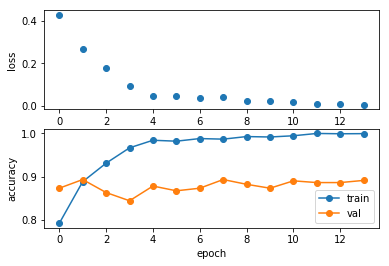

In [10]:
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

with open(os.path.join('/home/feng/ext2/feng/workspace/residential_building_challenge/20to2_output', 'results.csv'), 'r') as f:
        for line in f:
            numbers = line.split(',')
            if(numbers[0]=='epoch'):
                continue
            try:
                train_loss.append(float(numbers[1]))
                train_acc.append(1-float(numbers[2]))
                valid_loss.append(float(numbers[3]))
                valid_acc.append(1-float(numbers[4]))
            except ValueError:
                continue


# Visualize loss history and training/validation accuracy history
plt.subplot(2, 1, 1)
plt.plot(train_loss, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(train_acc, '-o')
plt.plot(valid_acc, '-o')
plt.legend(['train', 'val'], loc='lower right')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Test Model
Make predictions based on test dataset. Visually assess the quality of prediction and compute accuracy based on groundtruth. 

In [11]:
# Check accuracy of model on Test set
test_loader = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=False,
                                              pin_memory=(torch.cuda.is_available()), num_workers=0)
test_epoch(model, test_loader)

Test	Iter: [1/135]	Time 0.143 (0.143)	Loss 0.1444 (0.1444)	Error 0.0625 (0.0625)
Test	Iter: [2/135]	Time 0.109 (0.126)	Loss 0.8251 (0.4847)	Error 0.1875 (0.1250)
Test	Iter: [3/135]	Time 0.091 (0.114)	Loss 0.9044 (0.6246)	Error 0.1250 (0.1250)
Test	Iter: [4/135]	Time 0.092 (0.108)	Loss 0.2363 (0.5275)	Error 0.0625 (0.1094)
Test	Iter: [5/135]	Time 0.089 (0.104)	Loss 0.3990 (0.5018)	Error 0.1250 (0.1125)
Test	Iter: [6/135]	Time 0.088 (0.102)	Loss 0.2732 (0.4637)	Error 0.1875 (0.1250)
Test	Iter: [7/135]	Time 0.091 (0.100)	Loss 0.7862 (0.5098)	Error 0.1875 (0.1339)
Test	Iter: [8/135]	Time 0.091 (0.099)	Loss 0.4712 (0.5050)	Error 0.0625 (0.1250)
Test	Iter: [9/135]	Time 0.088 (0.098)	Loss 0.3612 (0.4890)	Error 0.1250 (0.1250)
Test	Iter: [10/135]	Time 0.090 (0.097)	Loss 0.0215 (0.4422)	Error 0.0000 (0.1125)
Test	Iter: [11/135]	Time 0.089 (0.096)	Loss 0.4463 (0.4426)	Error 0.0625 (0.1080)
Test	Iter: [12/135]	Time 0.086 (0.096)	Loss 0.9454 (0.4845)	Error 0.1875 (0.1146)
Test	Iter: [13/135]	Time 

Test	Iter: [103/135]	Time 0.083 (0.084)	Loss 0.5779 (0.5392)	Error 0.2500 (0.1286)
Test	Iter: [104/135]	Time 0.081 (0.084)	Loss 0.7243 (0.5410)	Error 0.1875 (0.1292)
Test	Iter: [105/135]	Time 0.084 (0.084)	Loss 1.3074 (0.5483)	Error 0.1250 (0.1292)
Test	Iter: [106/135]	Time 0.085 (0.084)	Loss 1.4792 (0.5571)	Error 0.1250 (0.1291)
Test	Iter: [107/135]	Time 0.082 (0.084)	Loss 0.7167 (0.5586)	Error 0.1250 (0.1291)
Test	Iter: [108/135]	Time 0.082 (0.084)	Loss 0.0850 (0.5542)	Error 0.0625 (0.1285)
Test	Iter: [109/135]	Time 0.082 (0.084)	Loss 0.5138 (0.5538)	Error 0.1250 (0.1284)
Test	Iter: [110/135]	Time 0.082 (0.084)	Loss 0.7589 (0.5557)	Error 0.1250 (0.1284)
Test	Iter: [111/135]	Time 0.083 (0.084)	Loss 0.3650 (0.5540)	Error 0.0625 (0.1278)
Test	Iter: [112/135]	Time 0.082 (0.084)	Loss 0.7684 (0.5559)	Error 0.1875 (0.1283)
Test	Iter: [113/135]	Time 0.082 (0.084)	Loss 0.1682 (0.5524)	Error 0.1250 (0.1283)
Test	Iter: [114/135]	Time 0.081 (0.084)	Loss 0.3300 (0.5505)	Error 0.1250 (0.1283)
Test

(0.08312457579153555, 0.5700603409408413, 0.1308193668528864)

### Visualize Successful and Failed Examples

In [ ]:
x = np.array([[1,2],[2,3],[3,4]])
mask = [False,False,True]
print(x)

In [ ]:
X_success = np.array([]).reshape((0, 1, 200, 200))
y_success = np.array([]).reshape((0,))
X_failure = np.array([]).reshape((0, 1, 200, 200))
y_failure = np.array([]).reshape((0,))

model.eval() 
for X, y in loader_test:
    X_var = Variable(X.type(dtype), volatile=True)
    scores = model(X_var)
    _, preds = scores.data.cpu().max(1)
    idx_success = (preds == y).numpy() == 1
    idx_failure = (preds != y).numpy() == 1
    X = X.numpy()
    y = y.numpy()
    X_success = np.append(X_success, X[idx_success.tolist(), :, :, :], axis=0)
    y_success = np.append(y_success, y[idx_success.tolist(), ], axis=0)
    X_failure = np.append(X_failure, X[idx_failure.tolist(), :, :, :], axis=0)
    y_failure = np.append(y_failure, preds[idx_failure.tolist(), ], axis=0)
    
y_success = y_success.astype(np.int32)
y_failure = y_failure.astype(np.int32)

In [ ]:
# Sample a batch of successfully classified images
for i in range(12):
    plt.subplot(3, 4, i+1)
    img = np.moveaxis(X_success[i, :, :, :], 0, -1)
    plt.imshow(img[:,:,0])
    plt.axis('off')
    plt.title(rbc_class_names[y_success[i]])
    plt.show()

In [ ]:
# Sample a batch of incorrectly classified images
plt.title('Failure Examples')
for i in range(8):
    plt.subplot(2, 4, i+1)
    img = np.moveaxis(X_failure[i, :, :, :], 0, -1)
    plt.imshow(img[:,:,0])
    plt.axis('off')
    plt.title(rbc_class_names[y_failure[i]])
    plt.show()